<a id="100"></a>
# <p style="padding:10px;background-color:#00bfff ;margin:0;color:#ffffff;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:800">Dog Breed Classification | VGG16(Imagenet) 🐕💥</p>

![](https://wallpapers.com/images/hd/adorable-dog-breeds-group-shot-7dd1igw7d22v4x3y.jpg)

<a id="0"></a>
# <p style="padding:10px;background-color:#00bfff ;margin:0;color:#ffffff;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:500">Dataset Description</p>

<div style = 'border : 3px solid non; background-color:#ebf5ff; border-radius : 10px;
              font-size:110%;padding:10px'>
    
**Description**:
    
This dataset contains a collection of images for 10 different dog breeds, meticulously gathered and organized to facilitate various computer vision tasks such as image classification and object detection. The dataset includes the following breeds:

* Golden Retriever
* German Shepherd
* Labrador Retriever
* Bulldog
* Beagle
* Poodle
* Rottweiler
* Yorkshire Terrier
* Boxer
* Dachshund
    
Each breed is represented by 100 images, stored in separate directories named after the respective breed. The images have been curated to ensure diversity and relevance, making this dataset a valuable resource for training and evaluating machine learning models in the field of computer vision.

<a id="1"></a>
# <p style="padding:10px;background-color:#00bfff ;margin:0;color:#ffffff;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:500">Importing Libraries</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image

import random

import warnings
warnings.filterwarnings("ignore")

import os
import os.path
from pathlib import Path
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass


2024-07-17 22:50:24.987539: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 22:50:24.987636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 22:50:25.116969: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<a id="2"></a>
# <p style="padding:10px;background-color:#00bfff ;margin:0;color:#ffffff;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:500">Data Preprocessing</p>

In [2]:
image_dir = Path('/kaggle/input/dog-breed-image-dataset/dataset')

filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [3]:
image_df

,Filepath,Label
0,/kaggle/input/dog-breed-image-dataset/dataset/...,Beagle
1,/kaggle/input/dog-breed-image-dataset/dataset/...,Beagle
2,/kaggle/input/dog-breed-image-dataset/dataset/...,Beagle
3,/kaggle/input/dog-breed-image-dataset/dataset/...,Beagle
4,/kaggle/input/dog-breed-image-dataset/dataset/...,Beagle
...,...,...
962,/kaggle/input/dog-breed-image-dataset/dataset/...,Dachshund
963,/kaggle/input/dog-breed-image-dataset/dataset/...,Dachshund
964,/kaggle/input/dog-breed-image-dataset/dataset/...,Dachshund
965,/kaggle/input/dog-breed-image-dataset/dataset/...,Dachshund


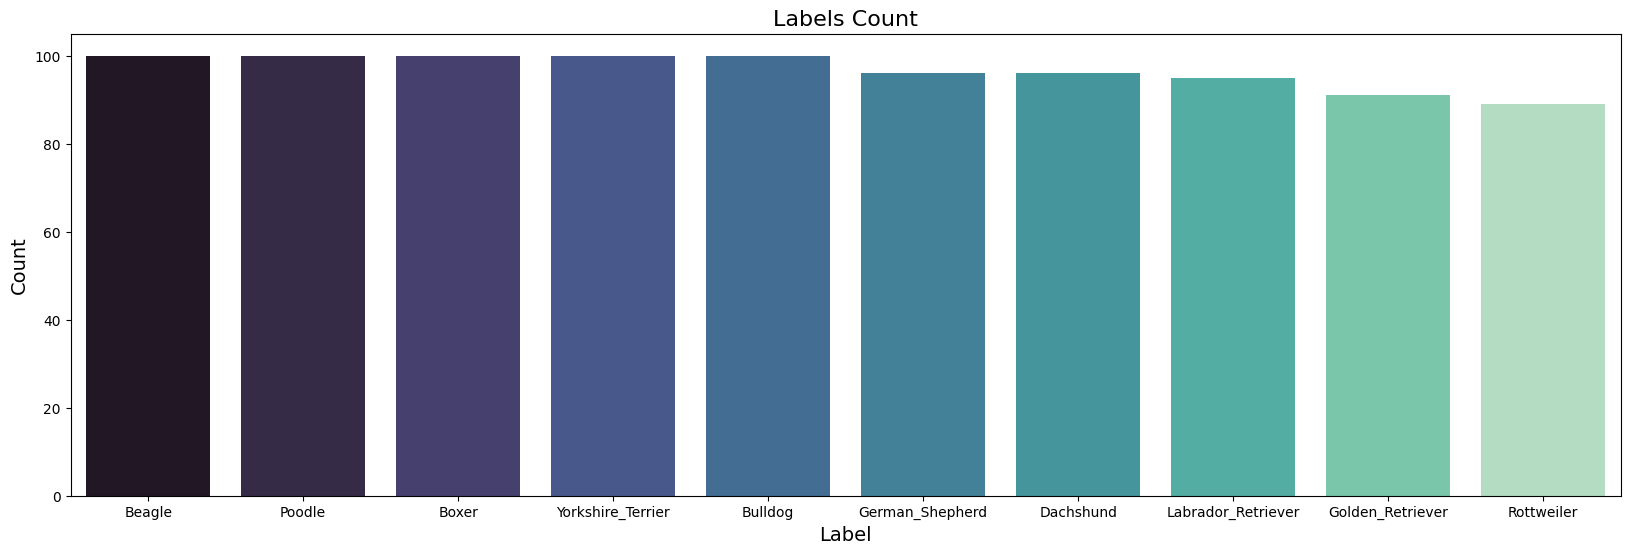

In [4]:
label_counts = image_df['Label'].value_counts()

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='mako')
plt.title('Labels Count', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

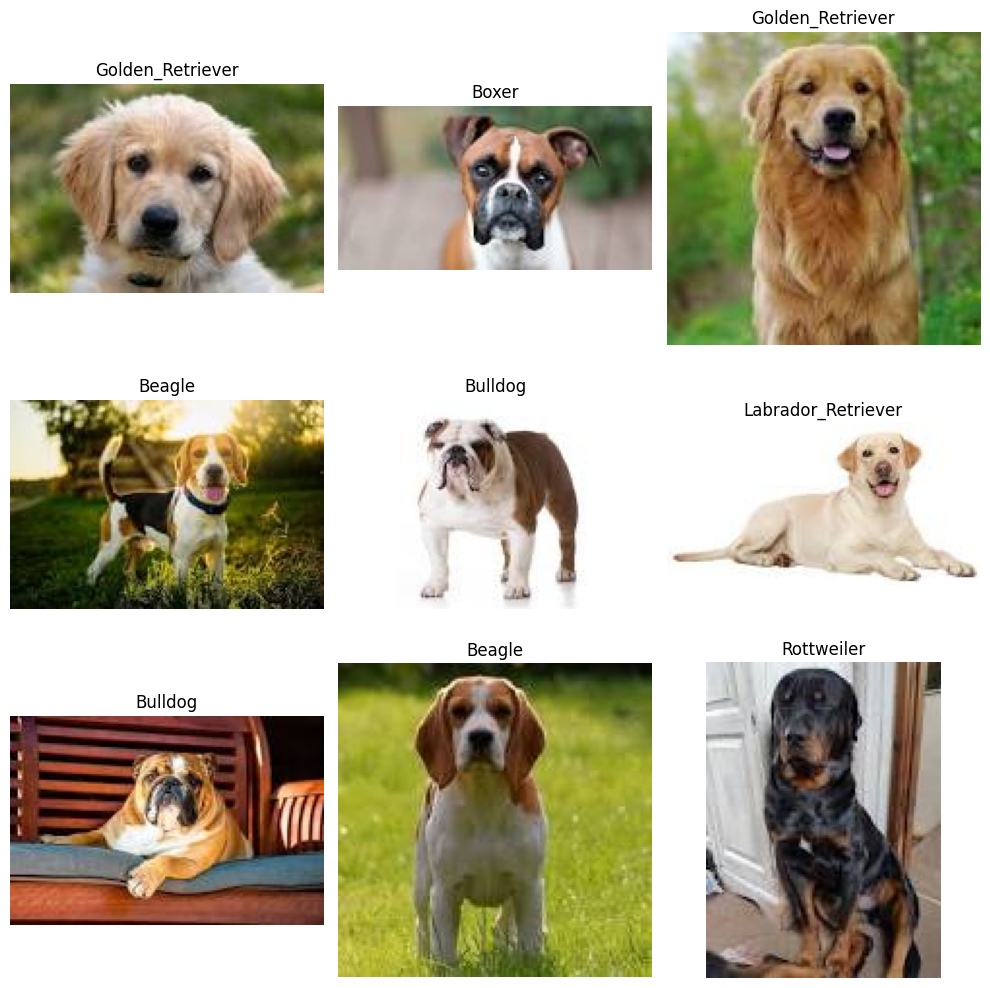

In [5]:
random_images = image_df.sample(n=9)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

for ax, (index, row) in zip(axes, random_images.iterrows()):
    img = Image.open(row["Filepath"])
    ax.imshow(img)
    ax.set_title(row["Label"])
    ax.axis("off")

plt.tight_layout()
plt.show()

In [6]:
def image_to_array(filepath, size=(150, 150)):
    img = Image.open(filepath).resize(size)
    return np.array(img)

X = np.array([image_to_array(filepath) for filepath in image_df["Filepath"]])
y = np.array(image_df["Label"])

In [7]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (967, 150, 150, 3)
y shape: (967,)


In [8]:
X = X.astype('float32')
X /= 255

In [9]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [10]:
y = to_categorical(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024, shuffle=True)

In [12]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (773, 150, 150, 3)
X_test shape: (194, 150, 150, 3)
y_train shape: (773, 10)
y_test shape: (194, 10)


<a id="3"></a>
# <p style="padding:10px;background-color:#00bfff ;margin:0;color:#ffffff;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:500">Model Config</p>

In [13]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
base_model.trainable = False

In [15]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

In [16]:
model = Model(inputs=base_model.input, outputs=predictions)

In [17]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,814,666 (64.14 MB)

 Trainable params: 2,099,978 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [20]:
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = test_datagen.flow(X_test, y_test, batch_size=32)

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

<a id="4"></a>
# <p style="padding:10px;background-color:#00bfff ;margin:0;color:#ffffff;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:500">Model Training</p>

In [22]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/50
 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.1250 - loss: 3.0598 

I0000 00:00:1721256665.200062      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721256665.224797      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/25 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - accuracy: 0.1768 - loss: 2.9920

W0000 00:00:1721256673.625206      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.1845 - loss: 2.9009

W0000 00:00:1721256675.256855      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 587ms/step - accuracy: 0.1859 - loss: 2.8852 - val_accuracy: 0.5670 - val_loss: 1.6080
Epoch 2/50


W0000 00:00:1721256679.222274      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.3517 - loss: 1.8273 - val_accuracy: 0.7113 - val_loss: 1.1965
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.4718 - loss: 1.4693 - val_accuracy: 0.8144 - val_loss: 0.8429
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.6229 - loss: 1.2226 - val_accuracy: 0.8557 - val_loss: 0.6999
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.6700 - loss: 1.0406 - val_accuracy: 0.8557 - val_loss: 0.5786
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.6608 - loss: 0.9880 - val_accuracy: 0.9021 - val_loss: 0.4209
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.6925 - loss: 0.8818 - val_accuracy: 0.9124 - val_loss: 0.4026
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.6954 - loss: 0.8599 - val_accuracy: 0.9330 - val_loss: 0.3121
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.7543 - loss: 0.7934 - val_accuracy: 0.9536 - val_

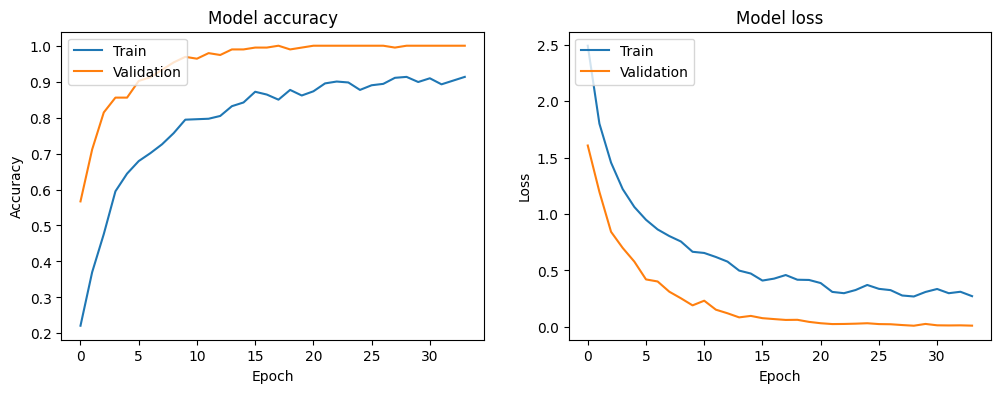

In [23]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [24]:
loss, accuracy = model.evaluate(validation_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.0109
Test Accuracy: 100.00%


In [25]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

W0000 00:00:1721256838.563683      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step


W0000 00:00:1721256839.511644      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


<a id="5"></a>
# <p style="padding:10px;background-color:#00bfff ;margin:0;color:#ffffff;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:500">Confusion Matrix</p>

In [26]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

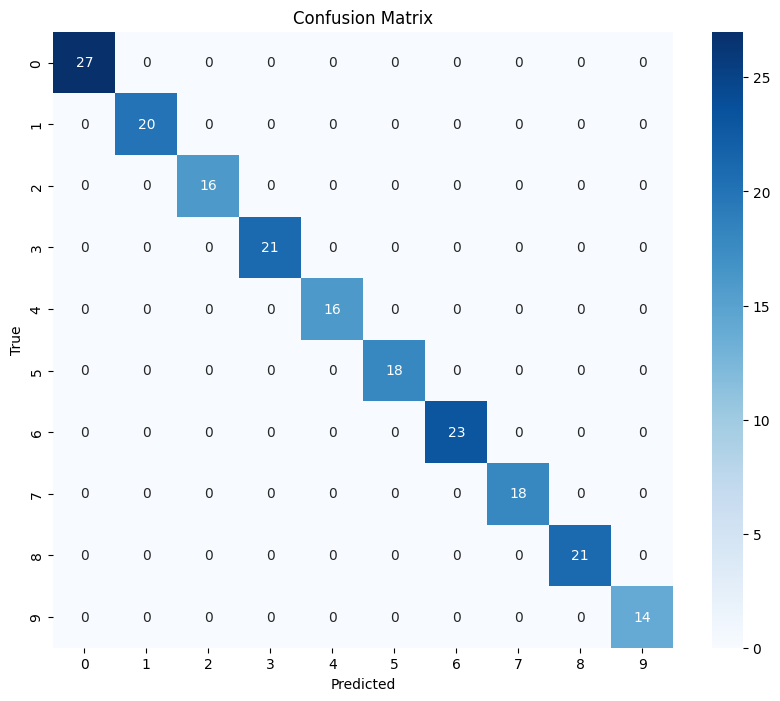

In [27]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

<a id="6"></a>
# <p style="padding:10px;background-color:#00bfff ;margin:0;color:#ffffff;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:500">Random Image Prediction</p>

In [28]:
def plot_images_with_predictions(X, y_true, y_pred, class_names, num_images=9):
    indices = random.sample(range(len(X)), num_images)
    images = X[indices]
    true_labels = y_true[indices]
    pred_labels = y_pred[indices]

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Actual: {class_names[true_labels[i]]}\nPredicted: {class_names[pred_labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
class_names = label_counts.index

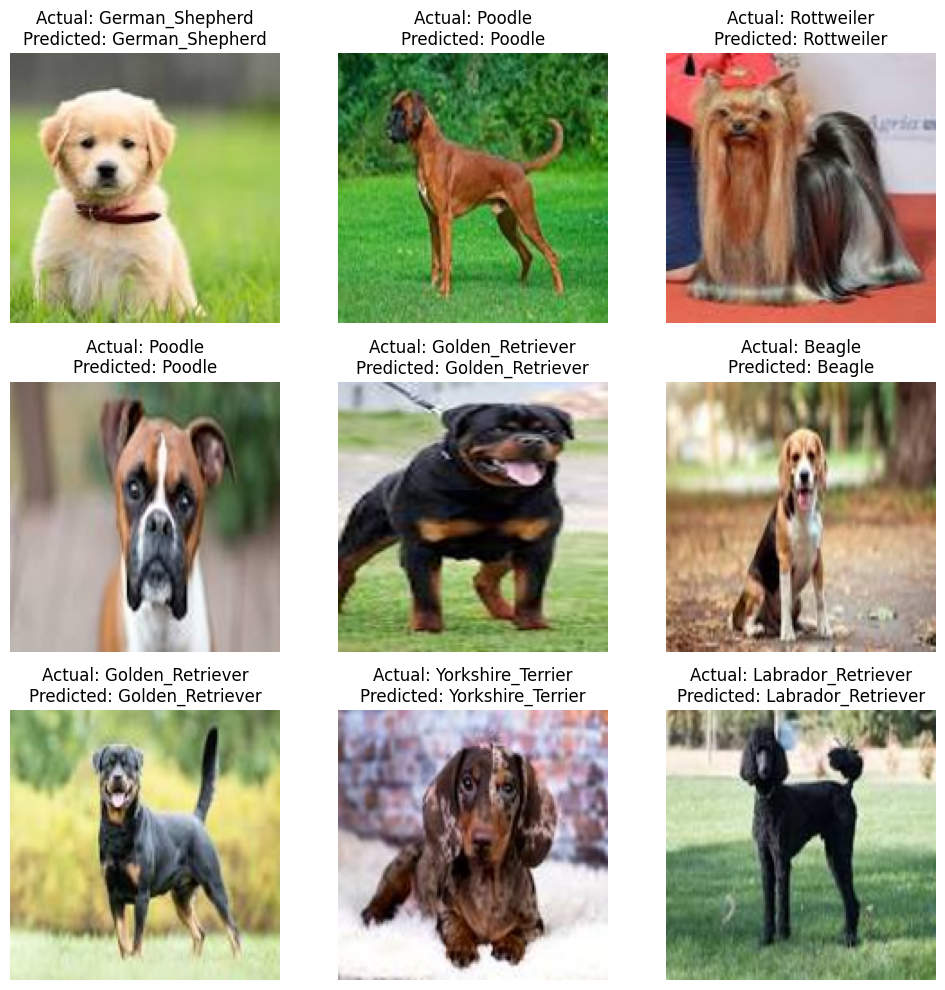

In [29]:
plot_images_with_predictions(X_test, y_true_classes, y_pred_classes, class_names)

<a id="7"></a>
# <p style="padding:10px;background-color:#00bfff ;margin:0;color:#ffffff;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:500">Thanks! 🙏🏻. Please upvote and leave comment if there is any question or idea for improvement.</p>